In [1]:
!pip install git+https://github.com/openai/CLIP.git
!gdown https://drive.google.com/uc?id=1--ePfiRJBywB6egaU3FoV-Y6qOGurAgx
!pip install transformers

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_8cp_573
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-_8cp_573
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=473f5e689068d83d2b12acd07ebdeff8b44649d293cfca451cdef7e7f0a59baf
  Stored in directory: /tmp/pip-ephem-wheel-cache-kayx0xh0/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
Downloading...
From: https://drive.google.com/uc?id=1--ePfiRJBywB6egaU3FoV-Y6qOGurAgx
To: /content/coco_prefix_latest.pt
100% 677M/677M [00:13<00:00, 51.5MB/s]
     |████████████████████████████████| 4.2 MB 8.5 MB/s 
     |████████████████████████████████| 6.6 MB 27.3 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstall

In [2]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm, trange
import PIL.Image
from IPython.display import Image 



device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_path = 'coco_prefix_latest.pt'



In [4]:
#title Model

class MLP(nn.Module):

    def forward(self, x):
        return self.model(x)

    def __init__(self, sizes, bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size, device):
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens, prefix, mask, labels):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length

        self.gpt = GPT2LMHeadModel.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')
        
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [5]:

clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 56.7MiB/s]


Downloading:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

In [6]:
prefix_length = 10
model = ClipCaptionModel(prefix_length)
model.load_state_dict(torch.load(model_path, map_location='cpu')) 
model.to(device)

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

ClipCaptionModel(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50264, 768)
      (wpe): Embedding(2048, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
       

In [7]:
import transformers

In [15]:
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  
        top_p=0.98,
        temperature=1.,
        stop_token = 'Изображен',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                #
                top_k = 2000 
                top_p = 0.98
                #print(logits)
                #next_token = transformers.top_k_top_p_filtering(logits.to(torch.int64).unsqueeze(0), top_k=top_k, top_p=top_p)
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)

                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
               
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [16]:



def _to_caption(pil_image):
    
    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    return generated_text_prefix



In [17]:
!wget https://ss.metronews.ru/userfiles/materials/169/1696646/858x429.jpg

--2022-05-20 12:52:03--  https://ss.metronews.ru/userfiles/materials/169/1696646/858x429.jpg
Resolving ss.metronews.ru (ss.metronews.ru)... 185.70.164.160, 185.70.164.161, 185.70.164.167, ...
Connecting to ss.metronews.ru (ss.metronews.ru)|185.70.164.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416687 (407K) [image/jpeg]
Saving to: ‘858x429.jpg.1’

858x429.jpg.1       100%[===================>] 406.92K   805KB/s    in 0.5s    

2022-05-20 12:52:05 (805 KB/s) - ‘858x429.jpg.1’ saved [416687/416687]



In [18]:
import PIL
image = PIL.Image.open('858x429.jpg')

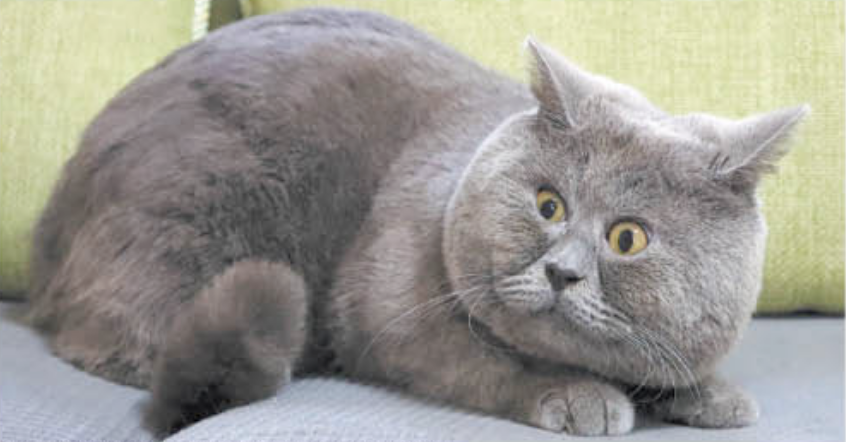

In [19]:
image

In [20]:

_to_caption(image)

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


'Кошка, сидящая на диване с глазами. \n 1.  В центре кадра находится кошка, сидящая на диване. \n 2.  В центре кадра находится кошка, сидящая на диване. \n 3.  В центре кадра находится кошка, сидящая на диване. \n 4.  В центре кадра находится'